In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

# Reflect Tables into SQLAlchemy ORM

In [2]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [3]:
# reflect an existing database into a new model
Database = automap_base( )

# reflect the tables
Database.prepare(engine, reflect=True)

# View all of the classes that automap found
Database.classes.keys( )

['measurement', 'station']

In [63]:
# Save references to each table 
Measuerement = Database.classes.measurement
Station = Database.classes.station

# Create our session (link) from Python to the DB
session = Session(bind=engine)
inspector = inspect(engine)

inspector.get_columns('station')

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'name',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'latitude',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'longitude',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'elevation',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

# Exploratory Precipitation Analysis
#### Design a query to retrieve the last 12 months of precipitation data and plot the results. 
Starting from the most recent data point in the database

In [5]:
# STEP 1: Find the most recent date in the data set.
earliest_date = session.query(Measuerement.date).order_by(Measuerement.date.desc()).first()

# STEP 2: Calculate the date one year from the last date in data set.
end_date = dt.datetime.strptime(earliest_date[0],'%Y-%m-%d') - dt.timedelta(days=365)

# STEP 3: Perform a query to retrieve the data and precipitation scores
prcp_12_mo_data = session.query(Measuerement.date, Measuerement.prcp).filter(Measuerement.date > end_date).all()

# STEP 4: Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_12_mo_data, columns=['date', 'prcp'])

# STEP 5: Sort the dataframe by date
prcp_df.sort_values('date',ascending=False)

# break the date into yr_mo for easier plotting
yr_mo = []
for date in prcp_df['date']:
    yr_mo.append(date[0:7])
prcp_df['yr_mo'] = yr_mo

Text(0.5, 1.0, '12 Month Precipitation')

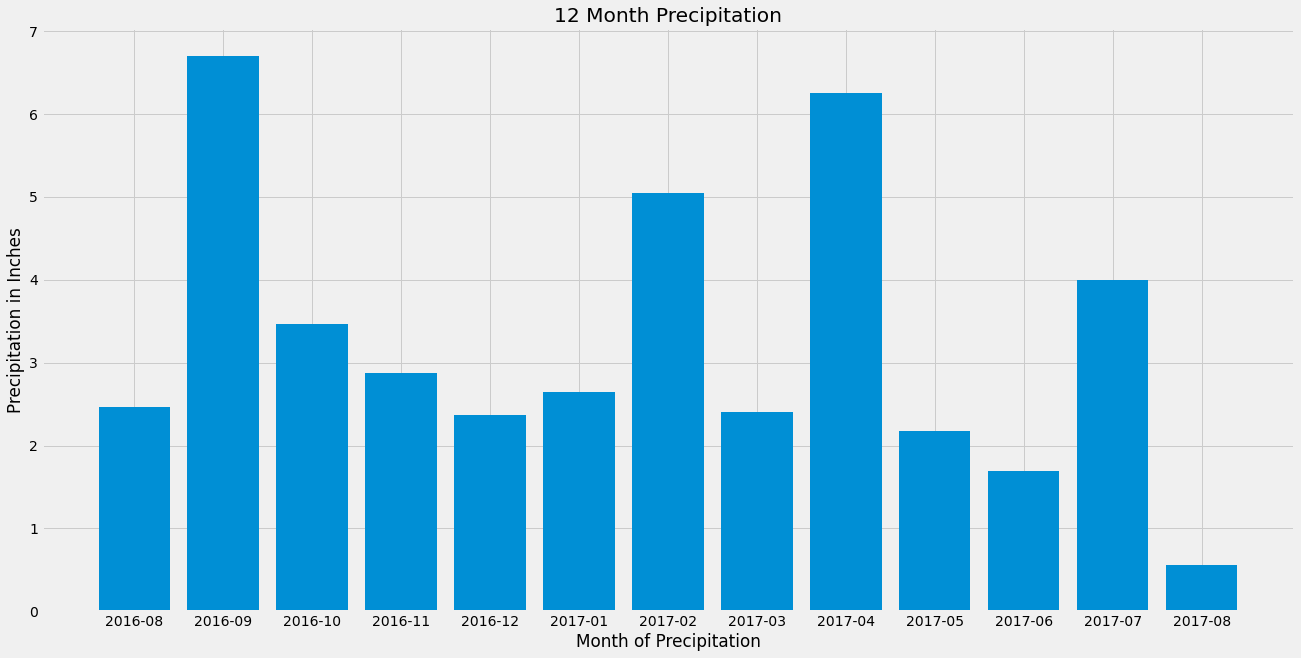

In [32]:
# STEP 5: Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(20,10))
plt.bar(prcp_df['yr_mo'], prcp_df['prcp'])
plt.xlabel('Month of Precipitation')
plt.ylabel('Precipitation in Inches')
plt.title('12 Month Precipitation')

In [49]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [8]:
# Design a query to calculate the total number stations in the dataset
active_stations = session.query(Measuerement).group_by(Measuerement.station).count()
active_stations

9

In [9]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations_count = engine.execute('SELECT station, COUNT(*) FROM measurement GROUP BY station ORDER BY count(*) DESC').fetchall()

# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations_count[0][0]

most_active_station_sumry = engine.execute(f'\
SELECT measurement.station, min(measurement.tobs), max(measurement.tobs), avg(measurement.tobs)\
FROM measurement \
WHERE measurement.station = "{most_active_station}" ').fetchall()

# store values for print statement
most_asctive_station_id = most_active_station_sumry[0][0]
most_asctive_station_min_tobs = most_active_station_sumry[0][1]
most_asctive_station_max_tobs = most_active_station_sumry[0][2]
most_asctive_station_avg_tobs = most_active_station_sumry[0][3]

#print most active station summary info
print(f'\
Station: {most_asctive_station_id}\n\
Min Temp: {most_asctive_station_min_tobs}\n\
Max Temp: {most_asctive_station_max_tobs}\n\
Avg Temp:{round(most_asctive_station_avg_tobs,1)}\n\
')

#### Query the last 12 months of temperature observation data for this station and plot the results as a histogram

Text(0.5, 1.0, 'Most Active Station Temperature')

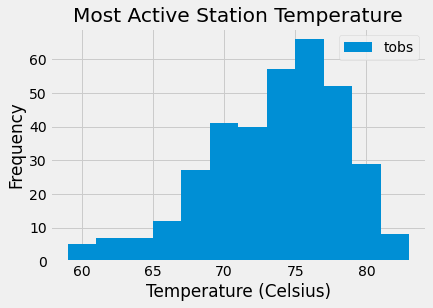

In [33]:
# STEP 1: Find the most recent date in the data set 
    # USE VARIABLE FROM ABOVE == earliest_date
    
# STEP 2: Calculate the date one year from the last date in data set 
    # USE VARIABLE FROM ABOVE == end_date

# STEP 3: Perform a query to retrieve the data and precipitation scores
tobs_12_mo_data = session.query(Measuerement.date, Measuerement.tobs)\
.filter(Measuerement.date > end_date)\
.filter(Measuerement.station == most_asctive_station_id)

# STEP 4: Save the query results as a Pandas DataFrame and set the index to the date column
tobs_df = pd.DataFrame(tobs_12_mo_data, columns=['date', 'tobs'])

# STEP 5: Sort the dataframe by date
tobs_df.sort_values('date',ascending=False)

# STEP 6: Plot the data in a histogram
tobs_df.plot.hist(bins=12)
plt.xlabel('Temperature (Celsius)')
plt.ylabel('Frequency')
plt.title('Most Active Station Temperature')

---

# Close session

In [31]:
# Close Session
session.close()